### Benchmark and plotting code

To run the benchmark, run this in a directory with `.mat` files that contain the metabolic networks. After the benchmark has ran all images can be generated with the following cells

In [2]:
from src.fvfa import FVAProblem
import numpy
import glob
import os
from scipy.io import loadmat

file_names = [os.path.basename(x) for x in glob.glob("*.mat")]
model_names = [x.split('.')[0] for x in file_names]

def read_file_mat(model_name: str, mu: float = 0.9):
    """
    Loads in a cobra formatted .mat file from a directory

    returns: FVAProblem from the given model_name
    """
    problem_mat = loadmat(f'{model_name}.mat')[model_name][0]
    S = numpy.array(problem_mat['S'][0]).astype(numpy.float64)
    lb = numpy.array(problem_mat['lb'][0]).astype(numpy.float64)
    ub = numpy.array(problem_mat['ub'][0]).astype(numpy.float64)
    c = numpy.array(problem_mat['c'][0]).astype(numpy.float64)
    return FVAProblem(S, ub, lb, c, mu)

In [3]:
from cobra.io import load_matlab_model
import time
import cobra
from cobra.flux_analysis import flux_variability_analysis
from src.fvfa import fva_solve_faster


def solve_cobra_model(model_name):
    try:

        cobra_model = load_matlab_model(f"{model_name}.mat")
        start = time.time()
        config = cobra.Configuration()
        config.max_cache_size = 0
        config.processes = 1
        config.solver = 'gurobi'
        cobra_sol = flux_variability_analysis(cobra_model, fraction_of_optimum=0.9)
        end = time.time()

        return end - start
    except:
        return None

def solve_fva_model(model_name):

    my_model = read_file_mat(model_name, 0.9)

    start = time.time()
    sol = fva_solve_faster(my_model)
    end = time.time()

    return end - start, sol.number_LPs, my_model.num_v(), my_model.num_v()*2+1, my_model.S.shape[0]

def bench_model(model_name):

    if model_name == "E_coupled":
        return f"{model_name}, {None}, {None}, {None}, {None}, {None}"

    time_my_algo, my_LPs, num_flux, cobra_LPs, num_mets = solve_fva_model(model_name)
    time_cobra = solve_cobra_model(model_name)
    ret = f"{model_name}, {num_flux}, {num_mets}, {my_LPs}, {cobra_LPs}, {time_my_algo}, {time_cobra}"
    print(ret)
    return ret


In [ ]:
import sys
import pandas

# import the correct package
if int(sys.version[0]) < 3:
    from StringIO import StringIO
else:
    from io import StringIO

bench_dat = ['model,flux,metabolites,LPNew,LPOld,TimeNew,TimeOld',*[bench_model(x) for x in model_names]]



In [5]:
csv_data = StringIO('\n'.join(bench_dat))
df = pandas.read_csv(csv_data, sep=',')

### Main Plot Generation Code

In [23]:
import matplotlib.pyplot as plt

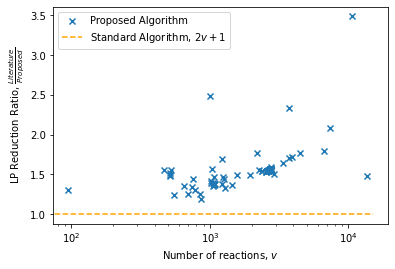

In [9]:
plt.scatter(df['flux'], df['LPOld']/ df['LPNew'], marker = 'x')
plt.plot([0, 15000], [1, 1], color = 'orange', linestyle = '--')
plt.xlabel(r'Number of reactions, $v$')
plt.ylabel(r'LP Reduction Ratio, $\frac{Literature}{Proposed}$')
plt.legend(['Proposed Algorithm','Standard Algorithm, $2v+1$',])
plt.xscale('log')
plt.savefig('LPcompare_rel.png', dpi = 400, facecolor='white')


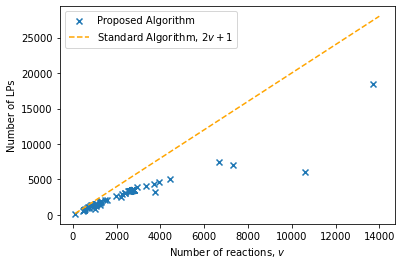

In [10]:
plt.scatter(df['flux'],  df['LPNew'], marker = 'x')
plt.plot([i for i in range(100,14000)], [2*i+1 for i in range(100,14000)], color = 'orange', linestyle = '--')
plt.xlabel(r'Number of reactions, $v$')
plt.ylabel(r'Number of LPs')
plt.legend(['Proposed Algorithm','Standard Algorithm, $2v+1$',])
plt.savefig('LPcompare.png', dpi = 400, facecolor='white')

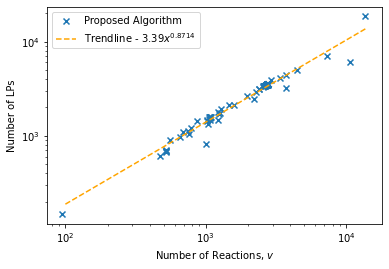

In [16]:
plt.scatter(df['flux'], df['LPNew'], marker = 'x')
plt.xscale('log')
plt.yscale('log')

x_axis = list(range(100,14000))
y_axis = list(map(lambda x: 3.39*x**(0.8714), x_axis))

plt.plot(x_axis, y_axis, color = 'orange', linestyle = '--')
plt.legend(['Proposed Algorithm',r'Trendline - $3.39x^{0.8714}$',])
plt.xlabel(r'Number of Reactions, $v$')
plt.ylabel(r'Number of LPs')
plt.savefig('trendline.png', dpi = 400, facecolor='white')

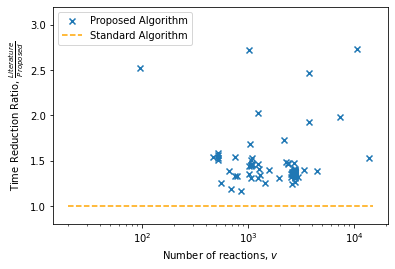

In [12]:
plt.scatter(df['flux'], df['TimeOld']/ df['TimeNew'], marker = 'x')
plt.plot([20, 15000], [1, 1], color = 'orange', linestyle = '--')
plt.xscale('log')
plt.xlabel(r'Number of reactions, $v$')
plt.ylabel(r'Time Reduction Ratio, $\frac{Literature}{Proposed}$')
plt.legend(['Proposed Algorithm','Standard Algorithm',], loc = 'upper left')
plt.savefig('')
plt.ylim((0.8,3.2))
plt.savefig('time_ratio.png', dpi = 400, facecolor='white')

In [14]:
df = df.dropna()
# calculate the average speed up factor between the old and new algorithm
numpy.average(df['TimeOld']/ df['TimeNew'])

1.4458932067632115